# **SemEval 2025 Task 9**

In [1]:
import pandas as pd
import re


from sklearn.metrics import recall_score, precision_score, f1_score
import numpy as np

import torch

from sklearn.metrics import f1_score

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    pipeline
)
from torch.utils.data import Dataset

!pip install nltk

import nltk
from nltk import bigrams
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# define file path
file_path = '/content/drive/MyDrive/NLP/'

In [4]:
# Load the training data for all subtasks

task1_eng = pd.read_csv(file_path + 'subtask1/train/eng.csv')
task1_swa = pd.read_csv(file_path + 'subtask1/train/swa.csv')

task2_eng = pd.read_csv(file_path + 'subtask2/train/eng.csv')
task2_swa = pd.read_csv(file_path + 'subtask2/train/swa.csv')

task3_eng = pd.read_csv(file_path + 'subtask3/train/eng.csv')
task3_swa = pd.read_csv(file_path + 'subtask3/train/swa.csv')

In [5]:
task1_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3222 entries, 0 to 3221
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            3222 non-null   object
 1   text          3222 non-null   object
 2   polarization  3222 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 75.6+ KB


In [6]:
task2_swa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6991 entries, 0 to 6990
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             6991 non-null   object
 1   text           6991 non-null   object
 2   political      6991 non-null   int64 
 3   racial/ethnic  6991 non-null   int64 
 4   religious      6991 non-null   int64 
 5   gender/sexual  6991 non-null   int64 
 6   other          6991 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 382.4+ KB


In [7]:
# check for presence of urls
url_pattern = r'https?://\S+|www\.\S+'

task1_eng['has_url'] = task1_eng['text'].str.contains(
    url_pattern,
    regex=True,
    na=False
)

task1_eng['has_url'].value_counts()

,count
has_url,
False,3222


In [8]:
task1_eng['text'].sample(6)

,text
1167,U.S. Rep. Summer Lee joins resolution calling ...
1689,1 Jewish state for hiding pedophiles @URL
3095,and if i said internalized xenophobia i would ...
710,"Ken Paxton, lawyers test limits of impeachment..."
947,Republicans weigh expelling Matt Gaetz after b...
2172,The red states are always begging for money.


In [9]:
!pip install langdetect

from langdetect import detect, DetectorFactory

DetectorFactory.seed = 0

def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

task1_eng['is_english'] = task1_eng['text'].apply(is_english)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=ebc5b4943f119c3607115c4c1986cc66052950a2d0476b2c983ba6569d588b36
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


In [10]:
not_en = task1_eng[task1_eng['is_english'] == False]['text']

for text in not_en:
  print(text)

A West Bank Pizza Restaurant Mocked Holocaust Survivor Taken
Albanians are neither refugees or asylum seekers
And as far as your gun control, Chicago knows gun control..
and they wonder why people dont like "asylum seekers"
Azerbaijani Flights to Israeli Arms Export Base Spike
Colorado voters sue to disqualify Donald Trump
Crean fake news sobre muerte de Jennifer
Didnt you request for his deportation ?
Do you want to sue Joe Biden? Kansas AG Kris Kobach
Doesnt she believe in open borders?
Donald Trump bashes Biden, DeSantis during Erie PA
Donald Trump Visits Versailles Cuban Restaurant
Eliminate electoral college! One person one vote!!
Energized GOP donors Trump best Biden
esp√±a digna lucha contra em neonazismo del IDF
ExPresident Trump skips GOP debate, holds rally
Former GOP state Sen. Jerry Sonnenberg enters 4th
Former judge lauds decision removing Donald Trump
Former President Donald Trump In ErieMeadville
GASD Board Yates gender identity not an issue
GAZA GAZA GAZA GAZA GAZA GAZA

In [22]:
# define function to plot pie for subtask1

def plot_pie_chart(data, language='English'):
  labels = ['non-polarized', 'polarized']

  colors = ['#5F9EA0', '#E3963E']
  ax = data['polarization'].value_counts().sort_index().plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    # figsize=(10, 10),
    labels=labels,
    colors=colors,
    textprops={'fontsize': 14}
)

  ax.set_ylabel('')   # remove y-axis label
  ax.set_xlabel('')
  ax.set_title(f'{language}')

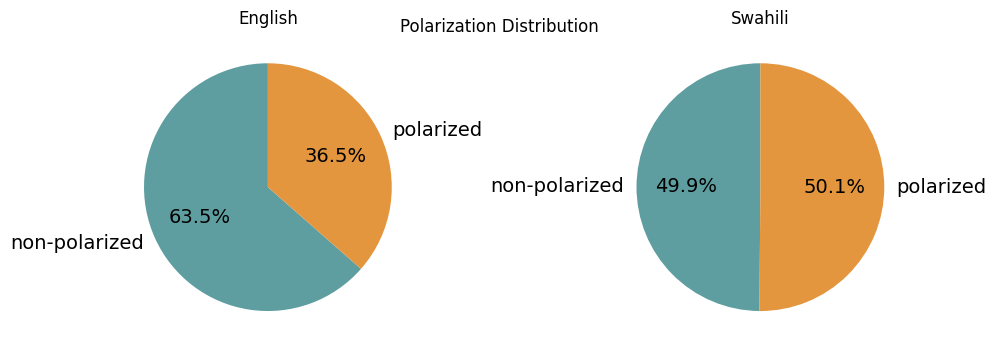

In [31]:
# pie charts horizontally
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plot_pie_chart(task1_eng, 'English')

plt.subplot(1, 2, 2)
plot_pie_chart(task1_swa, 'Swahili')

plt.suptitle('Polarization Distribution', y=0.8)
plt.tight_layout()
plt.savefig('/content/subtask1_distribution.pdf', format='pdf')
plt.show()


In [59]:
# define function to check labels distribution for subtask 2 and 3
def check_labels_distribution(df, language, color='blue'):
  cols = list(df.columns)
  cols.remove('id')
  cols.remove('text')

  labels = {}

  for col in cols:
    counts = df[col].sum()
    labels[col] = counts

  # find no of samples with non-polarized info

  no_cols = len(cols)

  if no_cols == 5:
    non_pols = len(df[(df[cols[0]] == 0) & (df[cols[1]] == 0) & (df[cols[2]] == 0) & (df[cols[3]] == 0) & (df[cols[4]] == 0)])

  elif no_cols == 6:
      non_pols = len(df[(df[cols[0]] == 0) & (df[cols[1]] == 0) & (df[cols[2]] == 0) & (df[cols[3]] == 0) & (df[cols[4]] == 0) & (df[cols[5]])])

  labels['non_polarized'] = non_pols

  # sort labels
  labels = dict(sorted(labels.items(), key=lambda item: item[1], reverse=True))

  plt.bar(labels.keys(), labels.values(), color=color)
  plt.xlabel('')
  plt.ylabel('Labels')
  plt.grid(True)
  plt.title(f'{language}')



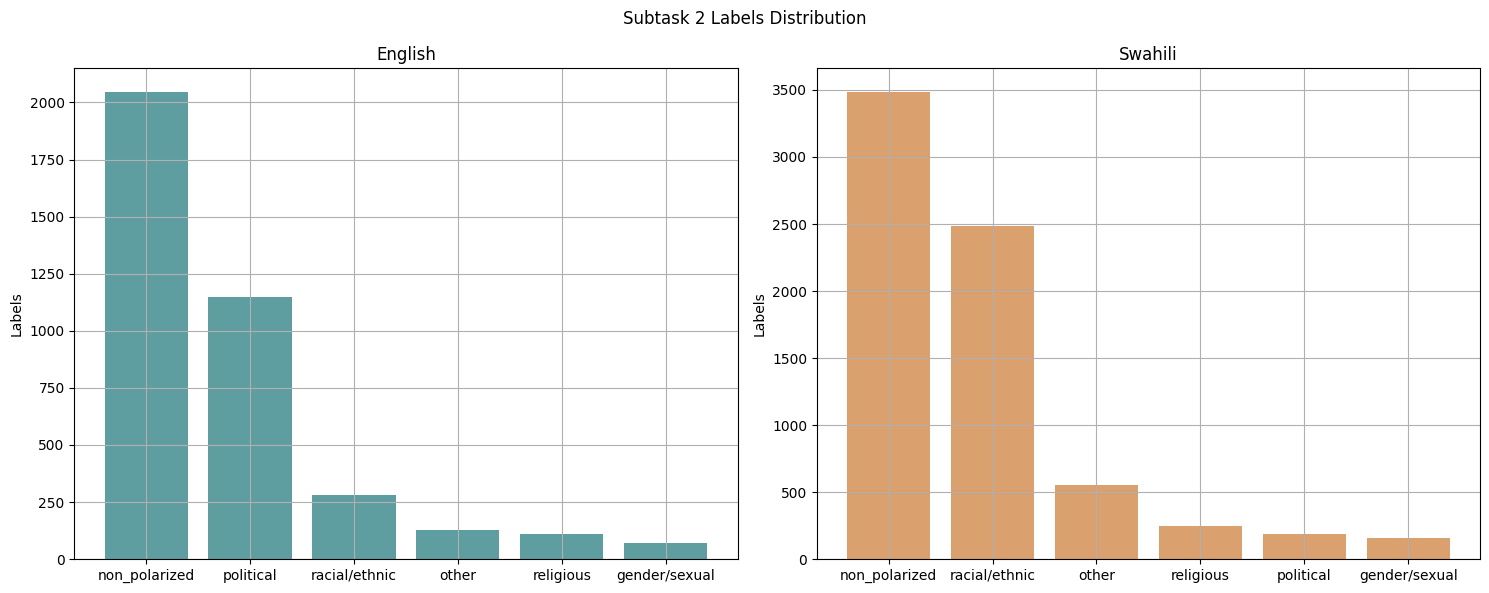

In [73]:
# subtask 2
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
check_labels_distribution(task2_eng, 'English', '#5F9EA0')

plt.subplot(1, 2, 2)
check_labels_distribution(task2_swa, 'Swahili', '#DAA06D')

plt.suptitle('Subtask 2 Labels Distribution')
plt.tight_layout()
plt.savefig('/content/subtask2_distribution.pdf', format='pdf')
plt.show()

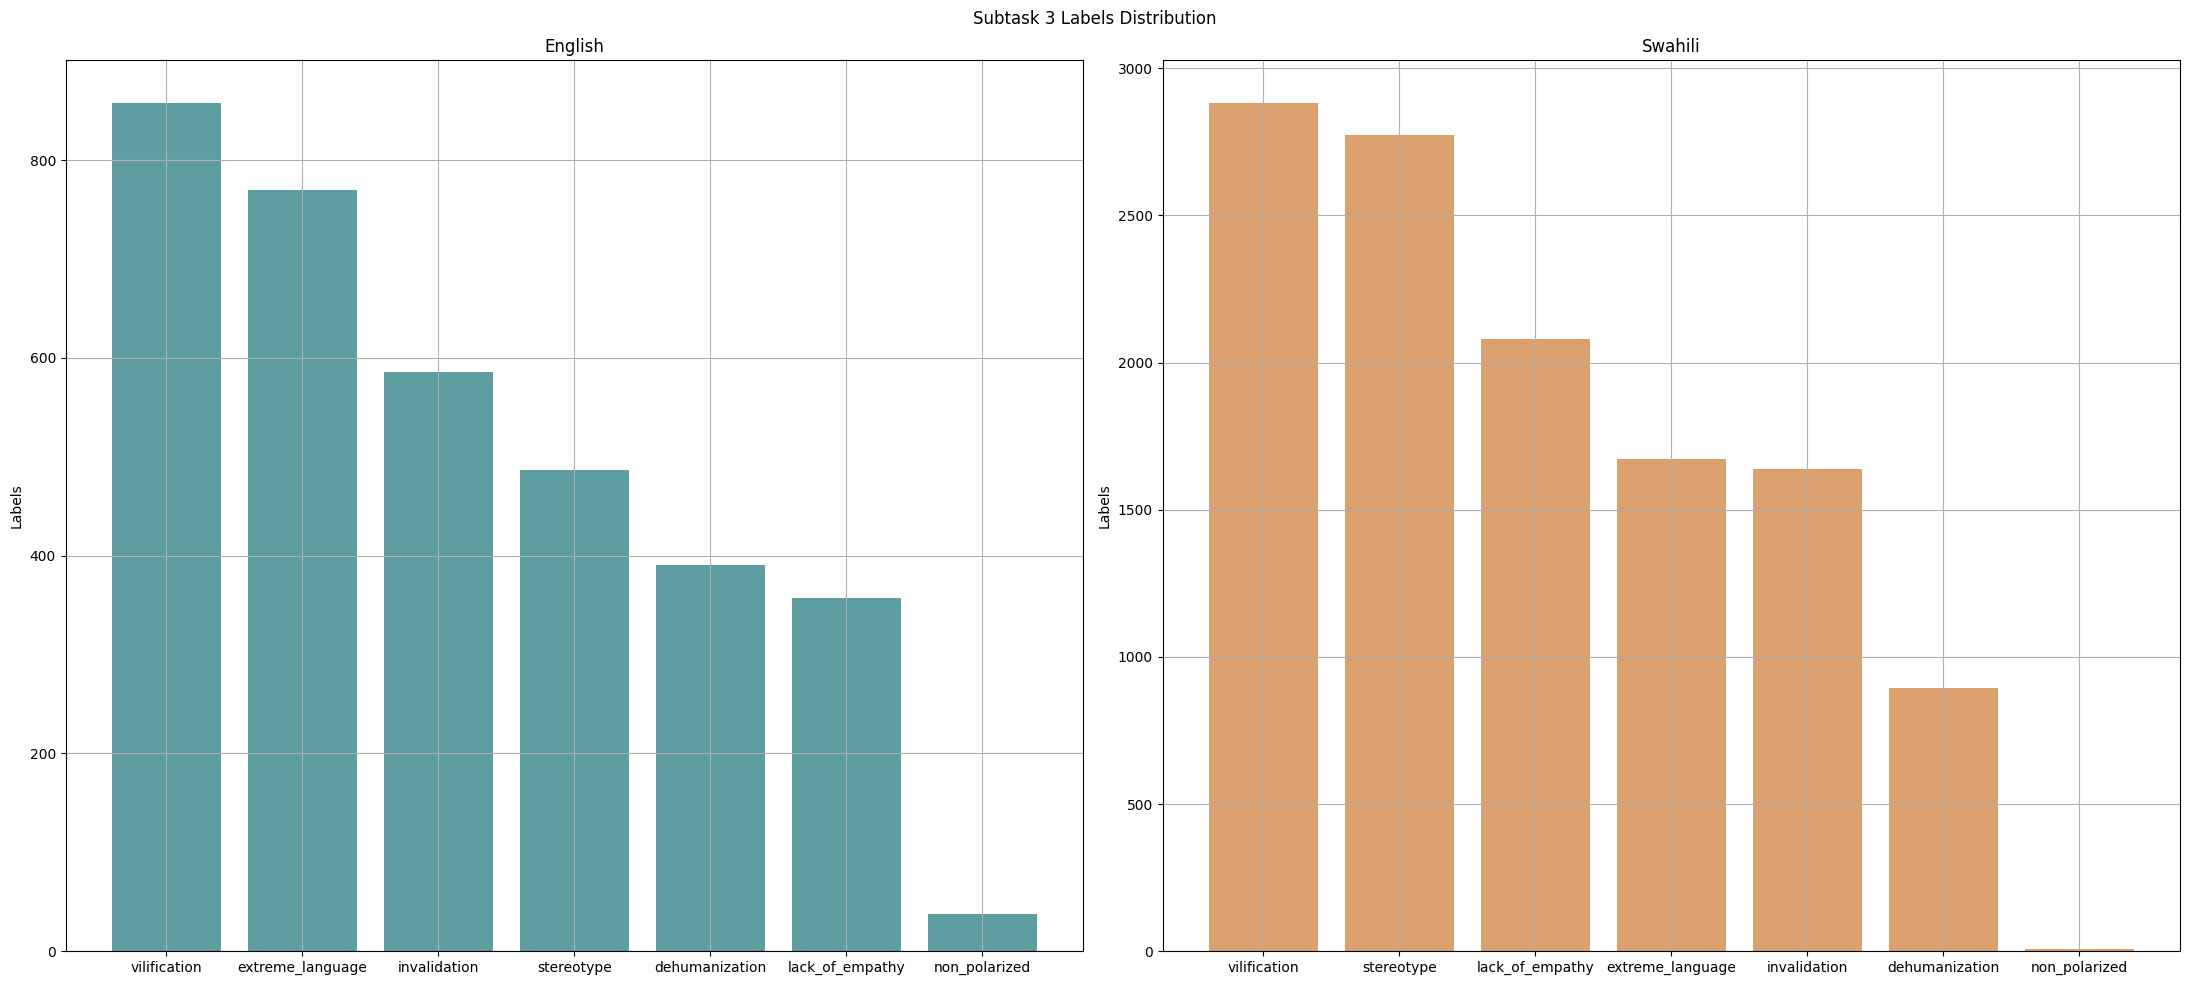

In [71]:
# subtask 3
plt.figure(figsize=(22, 10))
plt.subplot(1, 2, 1)
check_labels_distribution(task3_eng, 'English', '#5F9EA0')

plt.subplot(1, 2, 2)
check_labels_distribution(task3_swa, 'Swahili', '#DAA06D')

plt.suptitle('Subtask 3 Labels Distribution')
plt.tight_layout()
plt.savefig('/content/subtask3_distribution.pdf', format='pdf')
plt.show()

In [62]:
# finding overlapping classes

from itertools import combinations

def check_combinations_distribution(data, language, color='blue'):

  cols = list(data.columns)
  cols.remove('id')
  cols.remove('text')

  pairs = list(combinations(cols, 2))

  labels = {}

  for (label1, label2) in pairs:
    counts = len(data[(data[label1] == 1) & (data[label2] == 1)])
    labels[f'{label1} & {label2}'] = counts

  # sort labels by values
  labels = dict(sorted(labels.items(), key=lambda item: item[1]))

  plt.barh(labels.keys(), labels.values(), color=color)
  plt.xlabel('')
  plt.ylabel('Labels')
  plt.grid(True)
  #plt.xticks(rotation=45)
  return plt.title(f'{language}')

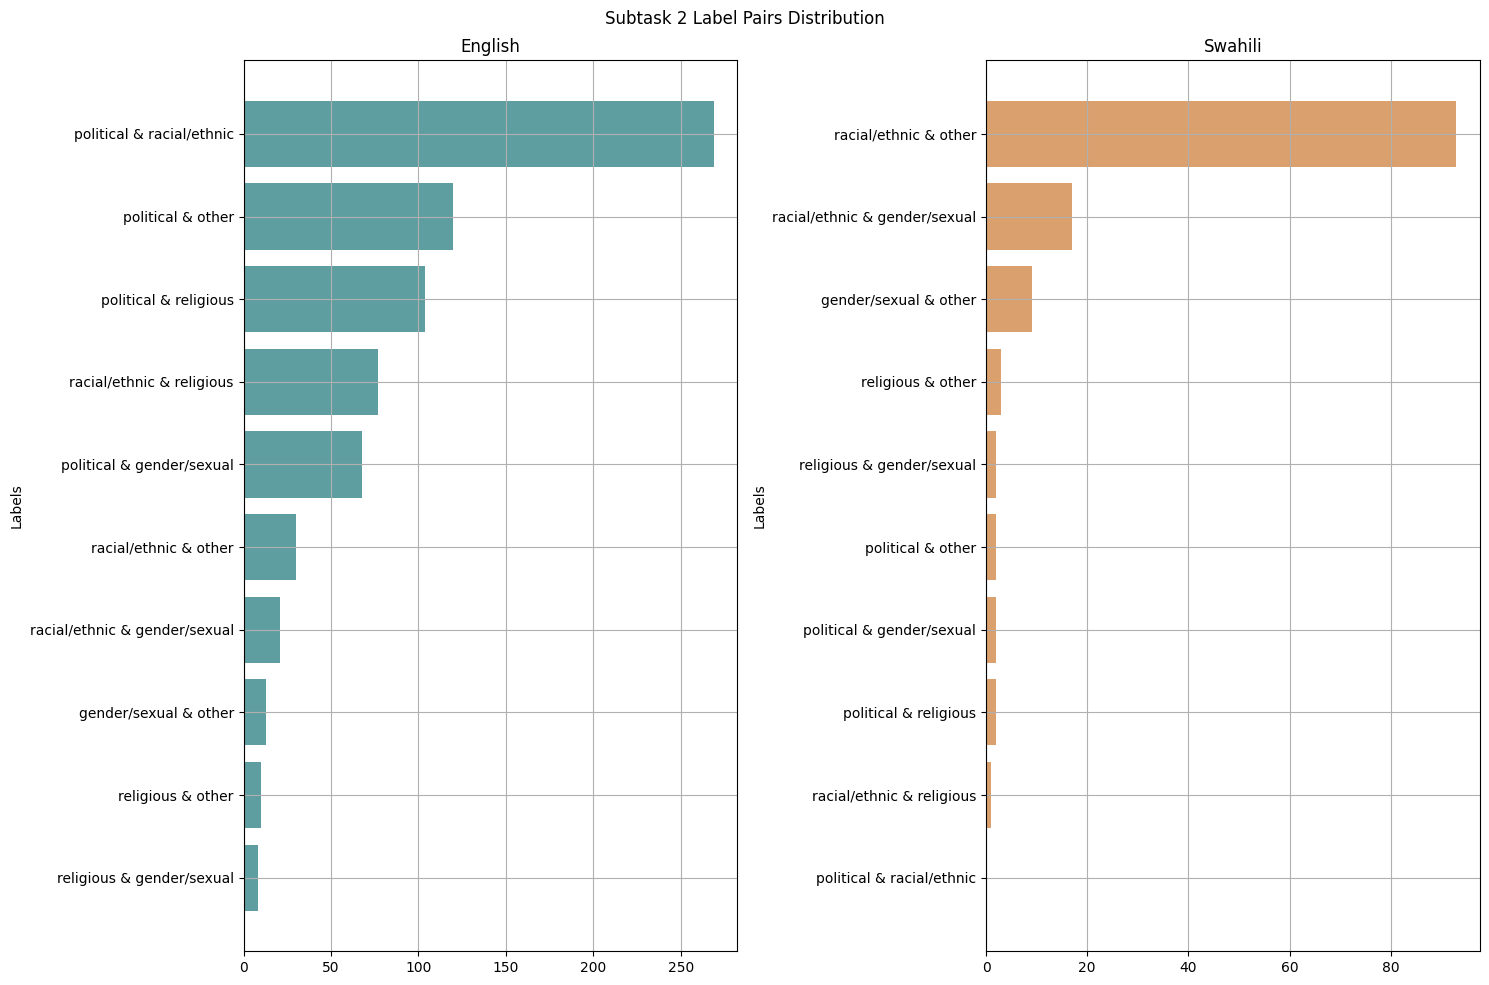

In [69]:
# subtask 2 label pairs
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
check_combinations_distribution(task2_eng, 'English', '#5F9EA0')

plt.subplot(1, 2, 2)
check_combinations_distribution(task2_swa, 'Swahili', '#DAA06D')

plt.suptitle('Subtask 2 Label Pairs Distribution')
plt.tight_layout()
plt.savefig('/content/subtask2_pairs_distribution.pdf', format='pdf')
plt.show()

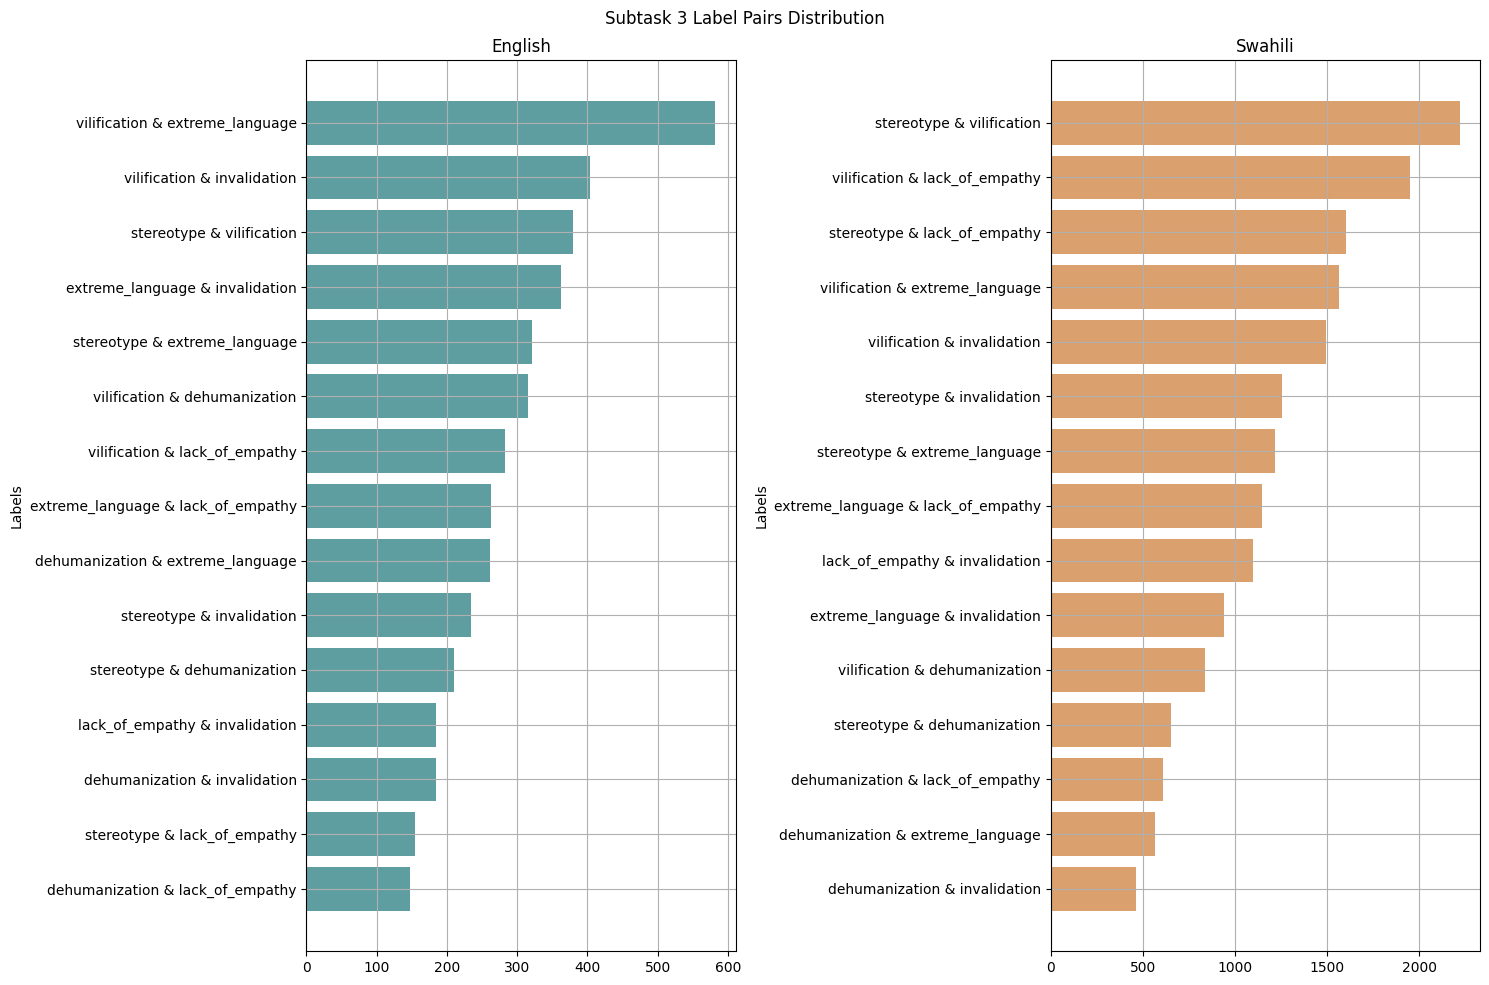

In [68]:
# subtask 3 label pairs
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
check_combinations_distribution(task3_eng, 'English', '#5F9EA0')

plt.subplot(1, 2, 2)
check_combinations_distribution(task3_swa, 'Swahili', '#DAA06D')

plt.suptitle('Subtask 3 Label Pairs Distribution')
plt.tight_layout()
plt.savefig('/content/subtask3_pairs_distribution.pdf', format='pdf')
plt.show()